In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from numba import jit, njit, vectorize
import time

## Defining functions that we need:

In [180]:
#Trial energy 1
def TrialEnergy1(alpha,omega,r1,r2):
    return 0.5*omega**2*(r1**2 + r2**2)*(1 - alpha**2) + 3*omega*alpha

@vectorize#By far the quickest of the three
def TrialEnergy1Vec(alpha,omega,r1,r2):
    #r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    #r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    return 0.5*omega**2*(r1**2 + r2**2)*(1 - alpha**2) + 3*omega*alpha

@jit(nopython=True)
def TrialEnergyJIT(alpha,omega,r1,r2):
    return 0.5*(omega**2)*(r1**2 + r2**2)*(1 - alpha**2) + 3*omega*alpha

@jit
def TrialWaveFunction1(alpha,omega,x1,y1,z1,x2,y2,z2):
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    return np.exp(-alpha*omega*(r1**2 + r2**2)/2)

In [198]:
alpha = 2
trialEnergyTemp = TrialEnergyJIT(alpha,1,0,0)
print(trialEnergyTemp)

6.0


## Monte Carlo and Metropolis algo:

In [181]:
#Probability ratio
@jit
def ProbRatio(Rold,Rnew,alpha,omega):#Rold and Rnew as an array
    new = TrialWaveFunction1(alpha,omega,Rnew[0],Rnew[1],Rnew[2],Rnew[3],Rnew[4],Rnew[5])
    new = new**2
    old = TrialWaveFunction1(alpha,omega,Rold[0],Rold[1],Rold[2],Rold[3],Rold[4],Rold[5])
    old = old**2
    return new/old

#Metropolis part
@jit
def Metropolis(Rold,Rnew,alpha,omega):
    Acceptance = False
    probRatio = ProbRatio(Rold,Rnew,alpha,omega)
    if probRatio > 1:
        Acceptance = True
    elif np.random.random() <= probRatio:
        Acceptance = True
    else:
        Acceptance = False
    return Acceptance

In [156]:
R1 = np.array([1,1,1,1,1,1])
R2 = np.array([2,2,2,2,2,2])
alpha = 1
omega = 1
print(Metropolis(R1,R2,alpha,omega))

a = np.array([1,2,3])
print(a+1)

False
[2 3 4]


In [227]:
#Monte Carlo part
@jit(nopython=True)
def MonteCarlo(MCCycles,omega,alpha,stepsize):
    #initalizing position randomly according to exponetial distribution
    x1 = np.random.exponential()
    y1 = np.random.exponential()
    z1 = np.random.exponential()
    x2 = np.random.exponential()
    y2 = np.random.exponential()
    z2 = np.random.exponential()
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    Rold = np.array([x1,y1,z1,x2,y2,z2])
    Energy = TrialEnergy1Vec(alpha,omega,r1,r2)
    #Step size for proposed steps
    DeltaR = stepsize
    #Counter for how many steps are accepted
    CounterAccept = 0
    #looping over MC cycles
    for i in range(MCCycles):
        #looping over each position, in total 6
        for l in range(6):
            randnum = (1+1)*np.random.random() - 1#creating random number on [-1,1]
            Rnew = np.copy(Rold)
            Rnew[l] = Rold[l] + randnum*DeltaR#The proposed move for each coordinate at a time
            #Metropolis test
            Acceptance = Metropolis(Rold,Rnew,alpha,omega)
            if Acceptance:#Moving the coordinates if the move is accepted
                Rold = Rnew
                CounterAccept += 1
        r1 = np.sqrt(Rold[0]**2 + Rold[1]**2 + Rold[2]**2)
        r2 = np.sqrt(Rold[3]**2 + Rold[4]**2 + Rold[5]**2)
        Energy += TrialEnergyJIT(alpha,omega,r1,r2)

    #End of MC loop
    #Analysis of relevant parameters
    Energy = Energy/MCCycles
    
    return Energy, CounterAccept/6

## Trial of the MC calculations:

49952.5
40756.5
35192.666666666664
31133.333333333332
29633.833333333332
27076.0
25093.833333333332
23635.5
22165.0
20963.666666666668


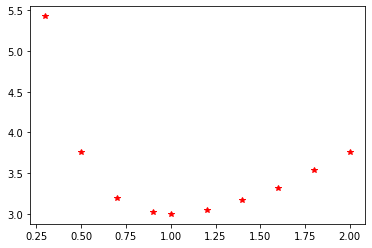

In [242]:
alpha = [0.3,0.5,0.7,0.9,1,1.2,1.4,1.6,1.8,2.0]
fig, ax = plt.subplots()
for alphaTemp in alpha:
    Energy, Counter = MonteCarlo(100000,1,alphaTemp,3.8)
    print(Counter)
    ax.plot(alphaTemp,Energy,'r*')

**Device a way to find the optimal step length for each alpha so that acceptance rate is around 50%**

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05
 2.1  2.15 2.2  2.25 2.3  2.35 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75
 2.8  2.85 2.9  2.95 3.   3.05 3.1  3.15 3.2  3.25 3.3  3.35 3.4  3.45
 3.5  3.55 3.6  3.65 3.7  3.75 3.8  3.85 3.9  3.95 4.   4.05 4.1  4.15
 4.2  4.25 4.3  4.35 4.4  4.45 4.5  4.55 4.6  4.65 4.7  4.75 4.8  4.85
 4.9  4.95 5.   5.05 5.1  5.15 5.2  5.25 5.3  5.35 5.4  5.45 5.5  5.55
 5.6  5.65 5.7  5.75 5.8  5.85 5.9  5.95 6.   6.05 6.1  6.15 6.2  6.25
 6.3  6.35 6.4  6.45 6.5  6.55 6.6  6.65 6.7  6.75 6.8  6.85 6.9  6.95
 7.   7.05 7.1  7.15 7.2  7.25 7.3  7.35 7.4  7.45 7.5  7.55 7.6  7.65
 7.7  7.75 7.8  7.85 7.9  7.95]
3.7
3.75
3.8000000000000003
3.85
3.9000000000000004


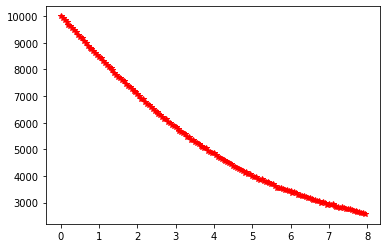

In [241]:
stepsize = np.arange(0,8,0.05)
print(stepsize)
alpha = 0.3
fig2, ax2 = plt.subplots()
for i in stepsize:
    Energy, Counter = MonteCarlo(10000,1,alpha,i)
    if (Counter >= 4900) and (Counter <= 5100):
        print(i)
    ax2.plot(i,Counter,'r*')

**Algorithm that takes care of this in a brute force way:**

In [254]:
def FindStepsize(stepsize,alpha):
    MCCycles = 10000
    M = len(alpha)
    StepSize = np.zeros(M)
    counter = 0
    for i in alpha:
        StepTemp = []
        for l in stepsize:
            Energy, Counter = MonteCarlo(10000,1,i,l)
            if (Counter >= 4900) and (Counter <= 5100):
                StepTemp.append(l)
        StepSize[counter] = np.median(StepTemp)
        counter += 1
        
    return StepSize

In [249]:
a = [1,2,3,4,5,6,6,6]
print(np.median(a))

4.5


In [255]:
#Trial
stepsize = np.arange(0,8,0.05)
alpha = np.arange(0.2,2,0.2)
print(alpha)
StepSize = FindStepsize(stepsize,alpha)

[0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8]


In [256]:
print(StepSize)

[4.65  3.3   2.675 2.35  2.075 1.9   1.75  1.65  1.525]


49860.166666666664
49886.833333333336
50146.0
49677.333333333336
50060.333333333336
49977.666666666664
50155.166666666664
49797.666666666664
50619.833333333336


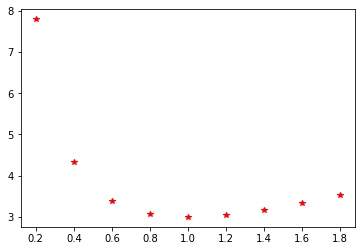

In [258]:
fig3, ax3 = plt.subplots()
for i in range(len(alpha)):
    stepTemp = StepSize[i]
    alphaTemp = alpha[i]
    Energy, Counter = MonteCarlo(100000,1,alphaTemp,stepTemp)
    print(Counter)
    ax3.plot(alphaTemp,Energy,'r*')